[Leveraging ESG Data to Operationalize Sustainability. November 11, 2020. Antoine Amend. Databricks](https://www.databricks.com/blog/2020/11/11/leveraging-esg-data-to-operationalize-sustainability.html)

https://www.databricks.com/notebooks/esgops_notebooks/01_vessel_etl.html

https://marinecadastre.gov/data/

[Office for Coastal Management, 2023: Nationwide Automatic Identification System 2022, https://www.fisheries.noaa.gov/inport/item/67336](https://www.fisheries.noaa.gov/inport/item/67336)

https://coast.noaa.gov/data/marinecadastre/ais/data-dictionary.pdf

### M.1371 : Technical characteristics for an automatic identification system using time division multiple access in the VHF maritime mobile frequency band (Rec. ITU-R M.1371-5 )

https://www.itu.int/rec/R-REC-M.1371-5-201402-I/en

In [0]:
dbutils.fs.mkdirs("/ais")

In [0]:
%sh
cd /ais
for i in {01..30}; do \
curl -O https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2022/AIS_2022_06_${i}.zip; \
unzip AIS_2022_06_${i}.zip; \
done

In [0]:
dbutils.fs.mv("/ais/AIS_2022_06_01.csv", "dbfs:/FileStore/tables/AIS_2022_06_01.csv")

Out[6]: True

etc.

In [0]:
dbutils.fs.ls("dbfs:/FileStore/tables")

Out[2]: [FileInfo(path='dbfs:/FileStore/tables/AIS_2022_06_01.csv', name='AIS_2022_06_01.csv', size=924871514, modificationTime=1683602866000),
 FileInfo(path='dbfs:/FileStore/tables/AIS_2022_06_02.csv', name='AIS_2022_06_02.csv', size=951920859, modificationTime=1683602896000),
 FileInfo(path='dbfs:/FileStore/tables/AIS_2022_06_03.csv', name='AIS_2022_06_03.csv', size=948612978, modificationTime=1683602937000),
 FileInfo(path='dbfs:/FileStore/tables/AIS_2022_06_04.csv', name='AIS_2022_06_04.csv', size=894550666, modificationTime=1683349405000),
 FileInfo(path='dbfs:/FileStore/tables/AIS_2022_06_05.csv', name='AIS_2022_06_05.csv', size=831107681, modificationTime=1683349518000),
 FileInfo(path='dbfs:/FileStore/tables/AIS_2022_06_06.csv', name='AIS_2022_06_06.csv', size=915449345, modificationTime=1683349799000),
 FileInfo(path='dbfs:/FileStore/tables/AIS_2022_06_07.csv', name='AIS_2022_06_07.csv', size=927239917, modificationTime=1683349858000),
 FileInfo(path='dbfs:/FileStore/tables/A

In [0]:
%sql
CREATE DATABASE IF NOT EXISTS ais

MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass

In [0]:
%scala
import org.apache.spark.sql.functions._

// Define the path to the CSV files
val path = "dbfs:/FileStore/tables/AIS_2022_06_*.csv"

// Read the CSV files into a DataFrame
val df = spark.read.format("csv")
  .option("header", "true")
  .option("inferSchema", "false")
  .schema(schema)
  .load(path)

// Add a new column for the file name
val dfWithFileName = df.withColumn("filename", input_file_name())

// Write the DataFrame to the Delta table
dfWithFileName.write.format("delta")
  .option("mergeSchema", "true")
  .mode("append")
  .saveAsTable("ais.june")


import org.apache.spark.sql.functions._
path: String = dbfs:/FileStore/tables/AIS_2022_06_*.csv
df: org.apache.spark.sql.DataFrame = [MMSI: string, BaseDateTime: timestamp ... 15 more fields]
dfWithFileName: org.apache.spark.sql.DataFrame = [MMSI: string, BaseDateTime: timestamp ... 16 more fields]

In [0]:
%scala
import org.apache.spark.sql.types._

val schema = StructType(
  List(
    StructField("MMSI",StringType,true), 
    StructField("BaseDateTime",TimestampType,true), 
    StructField("LAT",DoubleType,true), 
    StructField("LON",DoubleType,true), 
    StructField("SOG",DoubleType,true), 
    StructField("COG",DoubleType,true), 
    StructField("Heading",DoubleType,true), 
    StructField("VesselName",StringType,true), 
    StructField("IMO",StringType,true), 
    StructField("CallSign",StringType,true), 
    StructField("VesselType",IntegerType,true), 
    StructField("Status",IntegerType,true), 
    StructField("Length",DoubleType,true), 
    StructField("Width",DoubleType,true), 
    StructField("Draft",DoubleType,true), 
    StructField("Cargo",StringType,true), 
    StructField("TranscieverClass",StringType,true)
  )
)

import org.apache.spark.sql.types._
schema: org.apache.spark.sql.types.StructType = StructType(StructField(MMSI,StringType,true),StructField(BaseDateTime,TimestampType,true),StructField(LAT,DoubleType,true),StructField(LON,DoubleType,true),StructField(SOG,DoubleType,true),StructField(COG,DoubleType,true),StructField(Heading,DoubleType,true),StructField(VesselName,StringType,true),StructField(IMO,StringType,true),StructField(CallSign,StringType,true),StructField(VesselType,IntegerType,true),StructField(Status,IntegerType,true),StructField(Length,DoubleType,true),StructField(Width,DoubleType,true),StructField(Draft,DoubleType,true),StructField(Cargo,StringType,true),StructField(TranscieverClass,StringType,true))

In [0]:
from pyspark.sql.functions import count

# Read in the table
df = spark.read.table("ais.june")

# Count the number of entries in the table
num_entries = df.count()

# Show the number of entries
print("Number of entries in the ais.june table:", num_entries)

Number of entries in the ais.june table: 249326112


In [0]:
from pyspark.sql.functions import min, max

# Read the table into a DataFrame
df = spark.read.table("ais.june")

# Compute the minimum and maximum values for LAT and LON
min_lat, max_lat, min_lon, max_lon = df.agg(min("LAT"), max("LAT"), min("LON"), max("LON")).first()

# Print the results
print(f"Minimum LAT: {min_lat}, Maximum LAT: {max_lat}")
print(f"Minimum LON: {min_lon}, Maximum LON: {max_lon}")


Minimum LAT: -17.81994, Maximum LAT: 85.98074
Minimum LON: -175.26065, Maximum LON: 176.63515


https://spark.apache.org/docs/3.0.0/sql-ref-datetime-pattern.html

https://docs.databricks.com/sql/language-manual/functions/dayofmonth.html

In [0]:
%sql
SELECT dayofmonth(`BaseDateTime`) AS day, COUNT(*) AS total FROM ais.june
GROUP BY dayofmonth(`BaseDateTime`)
ORDER BY 1 ASC

day,total
1,8643158
2,8894850
3,8867322
4,8382322
5,7779307
6,8550315
7,8658144
8,8719021
9,8598970
10,8346129


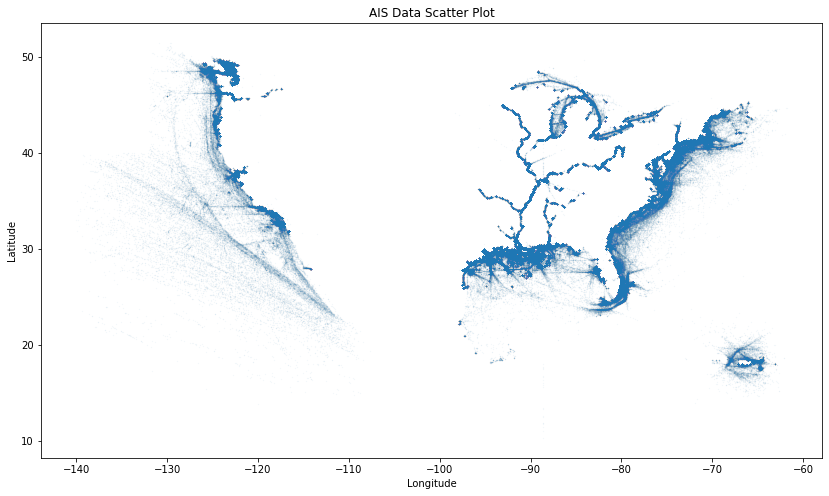

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Read the table into a DataFrame
df = spark.read.table("ais.june")

# Specify the bounding box
min_lat, max_lat, min_lon, max_lon = 10, 60, -140, -50

# Filter the data to only include points within the bounding box
df_filtered = df.filter((df["LAT"] >= min_lat) & (df["LAT"] <= max_lat) & \
                        (df["LON"] >= min_lon) & (df["LON"] <= max_lon))

# Sample the data (adjust the fraction to change the size of the sample)
df_sampled = df_filtered.sample(fraction=0.01, seed=42)

# Convert the Spark DataFrame to a pandas DataFrame
df_pandas = df_sampled.toPandas()

# Set the figure size
fig, ax = plt.subplots(figsize=(14, 8))

# Create a scatter plot using matplotlib
ax.scatter(df_pandas["LON"], df_pandas["LAT"], s=0.01, alpha=0.2)

# Set the plot title and axis labels
ax.set_title("AIS Data Scatter Plot")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()


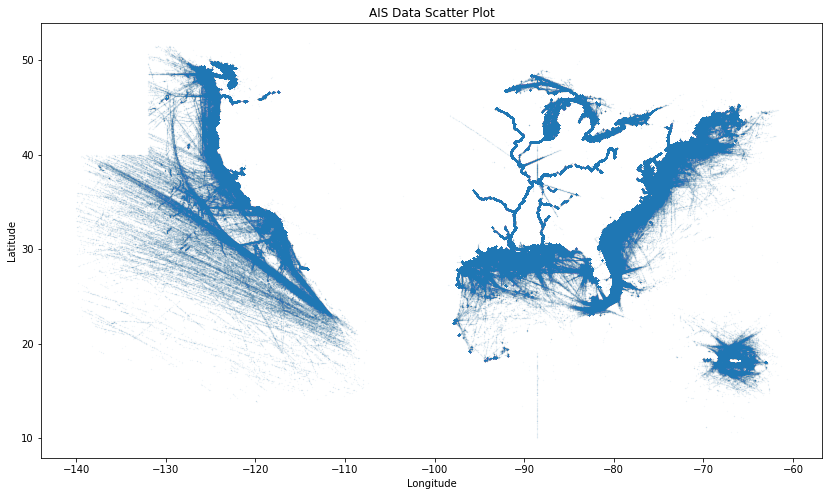

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Read the table into a DataFrame
df = spark.read.table("ais.june")

# Specify the bounding box
min_lat, max_lat, min_lon, max_lon = 10, 60, -140, -50

# Filter the data to only include points within the bounding box
df_filtered = df.filter((df["LAT"] >= min_lat) & (df["LAT"] <= max_lat) & \
                        (df["LON"] >= min_lon) & (df["LON"] <= max_lon))

# Sample the data (adjust the fraction to change the size of the sample)
df_sampled = df_filtered.sample(fraction=0.1, seed=42)

# Convert the Spark DataFrame to a pandas DataFrame
df_pandas = df_sampled.toPandas()

# Set the figure size
fig, ax = plt.subplots(figsize=(14, 8))

# Create a scatter plot using matplotlib
ax.scatter(df_pandas["LON"], df_pandas["LAT"], s=0.01, alpha=0.2)

# Set the plot title and axis labels
ax.set_title("AIS Data Scatter Plot")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()
